In [1]:
from base import *

In [2]:
import matplotlib.pyplot as plt
import pandas as pd #Obligé de passer par là pour pas avoir des dates en score
import pyspark.sql.functions as f
import unidecode
from nltk.corpus import stopwords #mots vides
import nltk
from pyspark.ml import Pipeline
from wordcloud import WordCloud
from nltk import everygrams


#Définition des pipes
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

In [3]:
#Préparation des dataframes
data = pd.read_csv('../csv/olist_order_reviews_dataset.csv')
data=data.dropna(subset=['review_comment_message'])
data['review_comment_message'] = data['review_comment_message'].astype(str)
data['review_comment_title'] = data['review_comment_title'].astype(str)
reviews = sqlContext.createDataFrame(data) #overwrite du review de base 


In [4]:
from pyspark.sql.types import *
def supAccent(x):
    return unidecode.unidecode(x)
supAccent = f.udf(supAccent, StringType())

def toString(x):
    res =""
    for mot in x:
        res += mot +" "
    return res
toString = f.udf(toString,StringType())

In [5]:
from pyspark.sql.types import IntegerType
reviews=reviews.select("review_score","review_comment_message")
reviews = reviews.withColumn('review_comment_message',supAccent(reviews.review_comment_message))

In [6]:
#Split des mots
regexTokenizer = RegexTokenizer(inputCol="review_comment_message",outputCol="tokenized", pattern="\\W") 


In [23]:
#Suppression stop words
stop_words =nltk.corpus.stopwords.words('portuguese')
newStopWords = ['produto','nao'] 
#stop_words.extend(newStopWords)#on va devoir garder nao pour les stopwords
stopwordsRemover = StopWordsRemover(inputCol="tokenized", outputCol="filtered").setStopWords(stop_words)


In [8]:
#count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

pipeline = Pipeline(stages=[regexTokenizer,stopwordsRemover,countVectors])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(reviews)
dataset = pipelineFit.transform(reviews)#.limit(10)
dataset = dataset.withColumn('review_string',toString(dataset.filtered))
dataset.show(5)

+------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|review_score|review_comment_message|           tokenized|            filtered|            features|       review_string|
+------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|           5|  Recebi bem antes ...|[recebi, bem, ant...|[recebi, bem, ant...|(3611,[1,3,5,10,1...|recebi bem antes ...|
|           5|  Parabens lojas la...|[parabens, lojas,...|[parabens, lojas,...|(3611,[29,36,44,5...|parabens lojas la...|
|           4|  aparelho eficient...|[aparelho, eficie...|[aparelho, eficie...|(3611,[33,60,103,...|aparelho eficient...|
|           4|  Mas um pouco ,tra...|[mas, um, pouco, ...|[pouco, travando,...|(3611,[28,92,116,...|pouco travando va...|
|           5|  Vendedor confiave...|[vendedor, confia...|[vendedor, confia...|(3611,[1,2,3,56,8...|vendedor confiave...|
+------------+----------

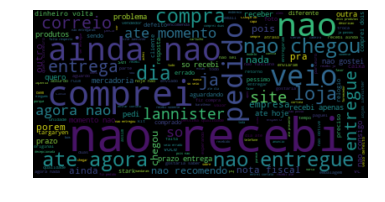

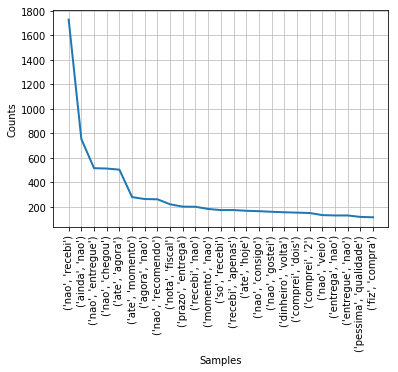

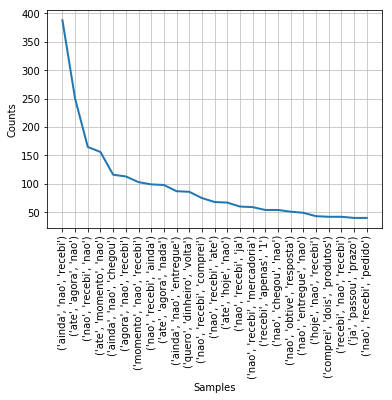

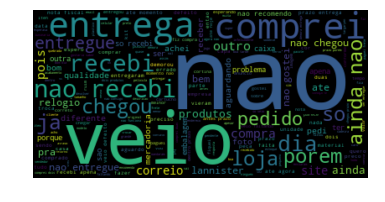

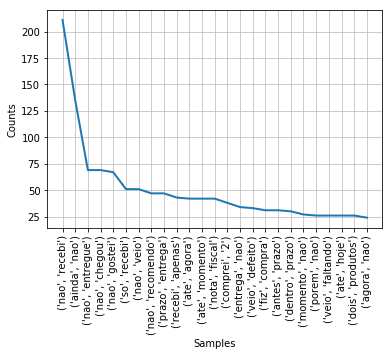

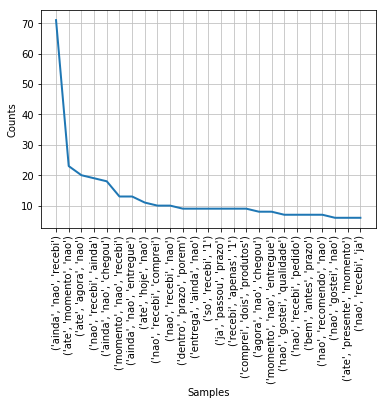

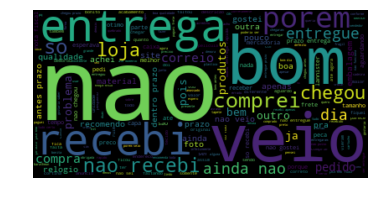

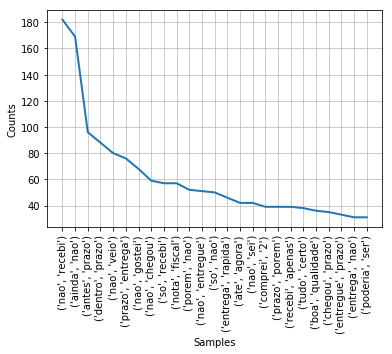

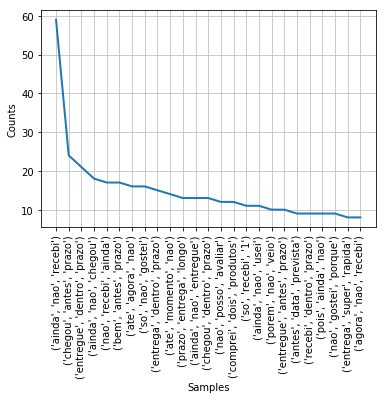

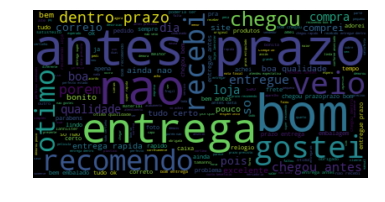

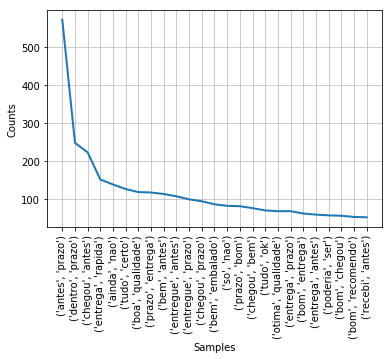

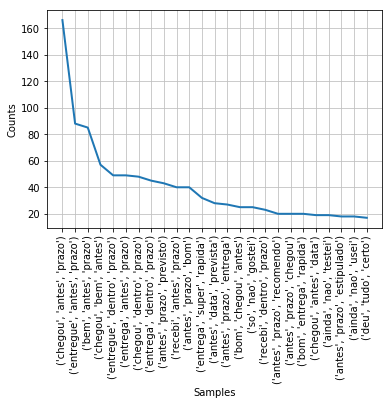

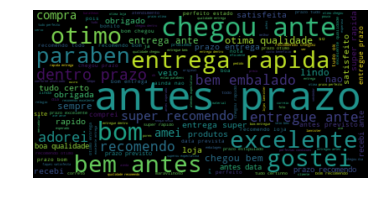

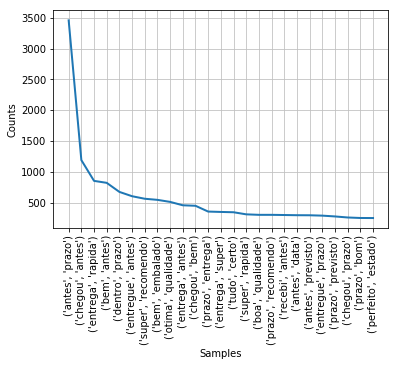

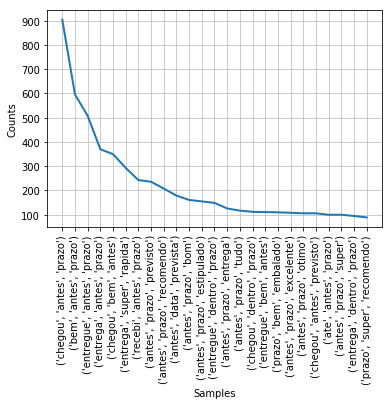

In [36]:
motsParNote={}
for x in range (1,6):
    motTmp=""
    for iteration in dataset.where(dataset.review_score == x).select("review_string").collect(): 
        motTmp += iteration.review_string+" "
    motsParNote[x]=motTmp
    
    #Wordclouds
    wordcloud = WordCloud(stopwords=stop_words).generate(motTmp)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    #NGrams
    bigrams=list(everygrams(motTmp.split(), 2, 2))
    trigrams=list(everygrams(motTmp.split(), 3, 3))
    nltk.FreqDist(bigrams).plot(25)
    nltk.FreqDist(trigrams).plot(25)

In [24]:
motsParNote

{1: 'pessimo  nao gostei comprei gato lebre  sempre compro internet entrega ocorre antes prazo combinado acredito ser prazo maximo stark prazo maximo ja esgotou ainda nao recebi  nada chegar pedido  recebi somente 1 controle midea split estilo faltou controle remoto ar condicionado consul  nao chegou prazo estipulado causou transtorno pq programei viagem ferias filho baseado prazo moro bahia cuiaba sozinho agora casa vazia  inferior mal acabado  pedi reembolso resposta ate momento  pedido balde 128 pecas blocos montar 2 un r 25 00 cada nao entregue vendido entregue targaryen tapete eva letras 36 pecas criancas 1 un r 35 90 entreg  comprei tres pacotes cinco folhas cada papel transfer tecido escuro so recebi dois  nao funciona nao faz sincronismo  chegou apenas peca nota garantia constam duas joias  nao recebi consta sistema recebi alem pagar caro frete  comprei relogio unissex enviaram relogio feminino bem menor especificacoes anuncio  peca nao serviu  comprei dia 25 fevereiro hoje dia

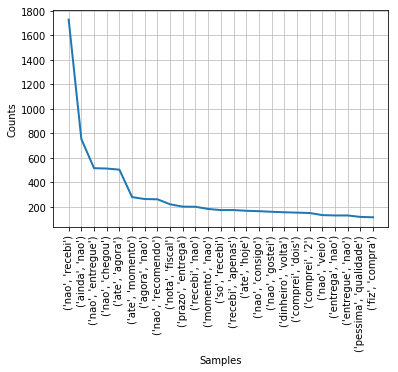

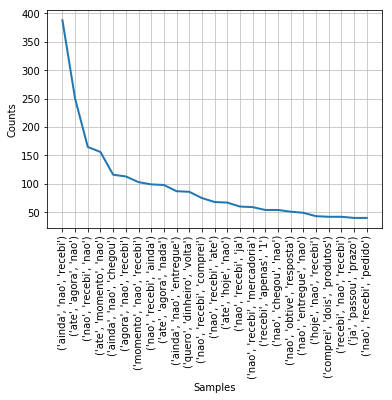